In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')


In [2]:
df = pd.read_csv('dataset/hourly_energy_consumption/PJMW_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

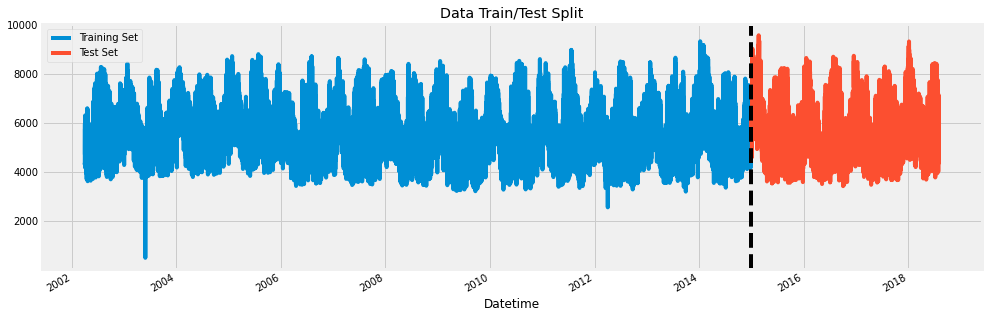

In [8]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

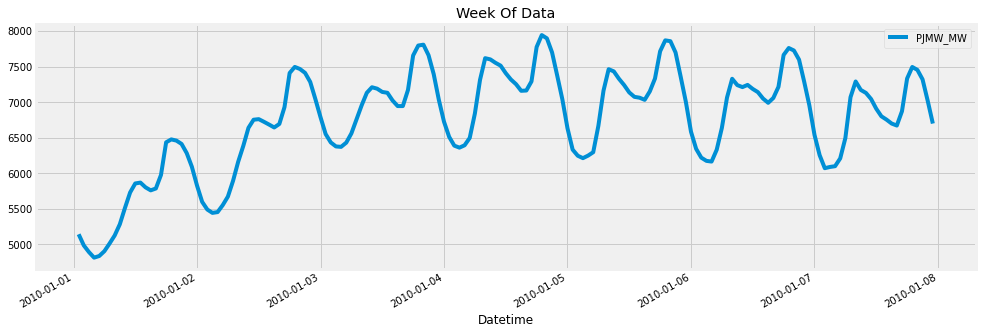

In [9]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

In [10]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

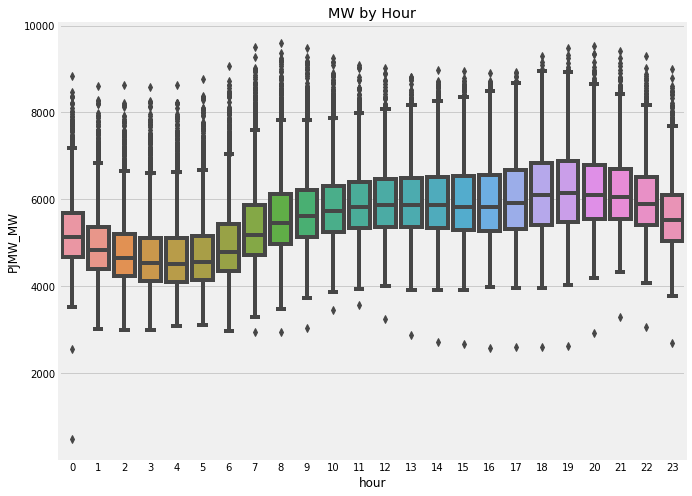

In [11]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='PJMW_MW')
ax.set_title('MW by Hour')
plt.show()

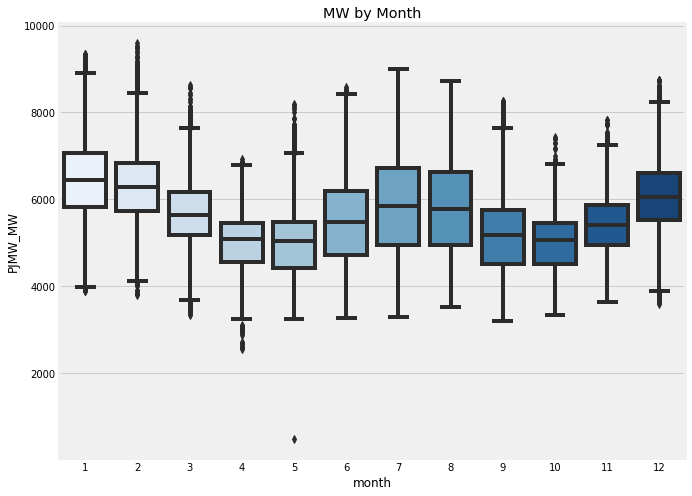

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJMW_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

In [14]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJMW_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [15]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[16:36:48] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:5625.61298	validation_1-rmse:5649.37183
[100]	validation_0-rmse:2153.53250	validation_1-rmse:2187.28584
[200]	validation_0-rmse:973.14173	validation_1-rmse:1047.32592
[300]	validation_0-rmse:639.71215	validation_1-rmse:752.64599
[400]	validation_0-rmse:554.43220	validation_1-rmse:683.87369
[500]	validation_0-rmse:526.71160	validation_1-rmse:666.60139
[600]	validation_0-rmse:511.37859	validation_1-rmse:661.03305
[700]	validation_0-rmse:501.24801	validation_1-rmse:658.79677
[800]	validation_0-rmse:493.93960	validation_1-rmse:658.52928
[900]	validation_0-rmse:487.41615	validation_1-rmse:657.49060
[999]	validation_0-rmse:481.70000	validation_1-rmse:657.47612


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, objective='reg:linear',
             predictor='auto', random_state=0, reg_alpha=0, ...)

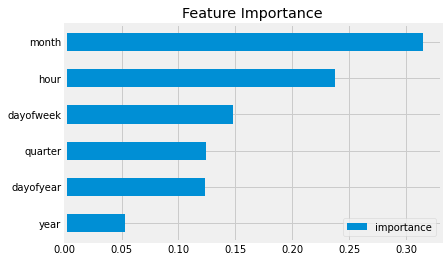

In [23]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

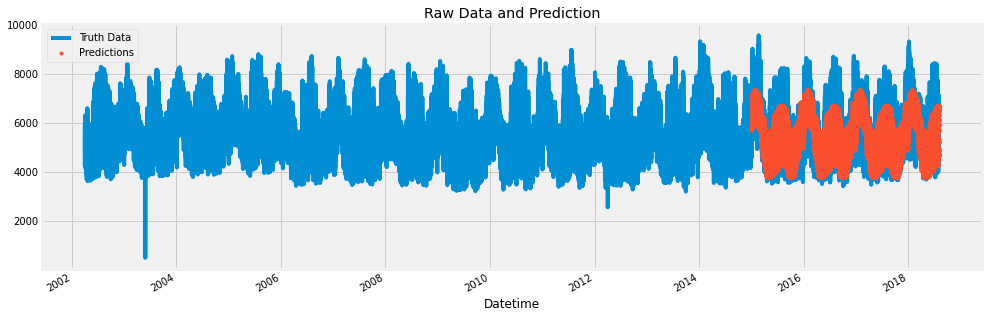

In [24]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['PJMW_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

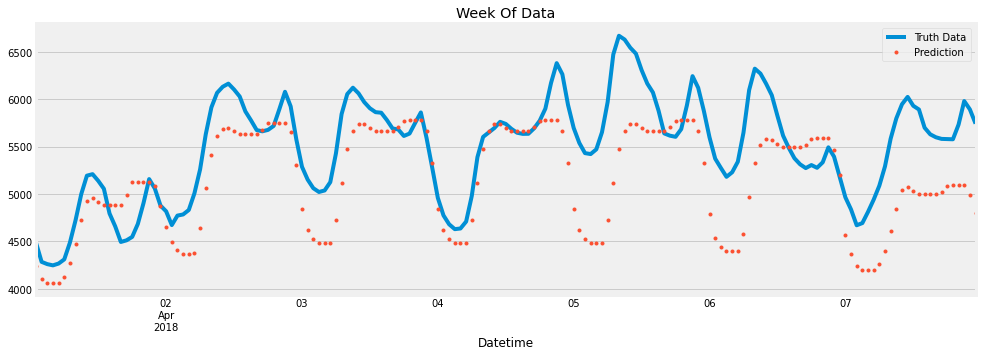

In [26]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJMW_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [28]:
score = np.sqrt(mean_squared_error(test['PJMW_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 656.84


In [29]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2018-01-06    2233.536255
2015-02-20    2093.426473
2018-01-05    2078.467753
2015-02-15    1984.970947
2017-12-31    1976.978963
2015-02-16    1958.889465
2015-02-19    1927.464355
2018-01-07    1859.486755
2017-02-24    1774.728902
2017-12-28    1762.660828
Name: error, dtype: float64